In [2]:

import pandas as pd
import numpy as np
from unidecode import unidecode
from libpysal.weights.contiguity import Queen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#df_f0=pd.read_excel("Bases//Base_Limpia.xlsx")

from scipy.stats import pearsonr, chi2_contingency

df_f=pd.read_csv("Bases//Base_Limpia_Added.csv")

In [3]:
df=df_f.copy()
df_aux=df_f.copy()


In [4]:
# Convert 'fecha' and 'fecha_fin_trat' to datetime
df_aux['fecha'] = pd.to_datetime(df_aux['fecha'])
df_aux['fecha_fin_trat'] = pd.to_datetime(df_aux['fecha_fin_trat'])

# Create a date range covering all weeks from the earliest start to the latest end date
weekly_dates = pd.date_range(start=df_aux['fecha'].min(), end=df_aux['fecha_fin_trat'].max(), freq='W')

# Create columns for each week and province with the number of active cases
for week_start in weekly_dates:
    week_end = week_start + pd.Timedelta(days=6)
    week_label = week_start.strftime("%Y-%m-%d")
    
    df_aux[week_label] = ((df_aux['fecha'] <= week_end) & (df_aux['fecha_fin_trat'] >= week_start)).astype(int)

# Group by province and department, summing the active cases for each week
df_casos_activos_depto = pd.DataFrame(df_aux.groupby(['provincia', 'departamento'])[weekly_dates.strftime('%Y-%m-%d')].sum().to_records())

# Select specific weekly columns for further analysis
selected_weeks = list(df_casos_activos_depto.columns[200:213])
df_casos_activos_depto_fecha = df_casos_activos_depto[['provincia', 'departamento'] + selected_weeks]


In [8]:
import geopandas as gpd
from utils import utils

# Load the shapefile using geopandas
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)

# Clean province and department names
dataframe_shp["provincia"] = dataframe_shp["provincia"].apply(utils.quitar_acentos_limpiar).str.replace("Ciudad Autonoma de Buenos Aires", "Caba")
dataframe_shp["departamen"] = dataframe_shp["departamen"].apply(utils.quitar_acentos_limpiar)

# Copy and clean department data
df_deptos = df_f.copy()
df_deptos.loc[(df_deptos["departamento"] == "Desconocido") | (df_deptos["departamento"] == "Nan"), "departamento"] = np.nan
df_deptos = df_deptos.loc[(~df_deptos["departamento"].isnull()) & (df_deptos["departamento"] != "")]
df_deptos["departamento"] = df_deptos["departamento"].str.replace("Gral manuel belgrano", "Dr. manuel belgrano")
df_deptos["AUX"] = 1

# Display unique department names
df_deptos["departamento"].unique()


array(['ALMIRANTE BROWN', 'BAHIA BLANCA', 'BERAZATEGUI', 'EZEIZA',
       'FLORENCIO VARELA', 'GENERAL PUEYRREDON', 'LA MATANZA', 'LA PLATA',
       'MERLO', 'Comuna 15', 'Comuna 10', 'Comuna 7', 'Comuna 9',
       'COMANDANTE FERNANDEZ', 'CAPITAL', 'RIO CUARTO', 'FORMOSA',
       'GRAL MANUEL BELGRANO', 'OBERA', 'SAN IGNACIO',
       'GENERAL SAN MARTIN', '9 DE JULIO', 'LA CAPITAL', 'ROSARIO',
       'LEALES', 'ESTEBAN ECHEVERRIA', 'LOMAS DE ZAMORA',
       'MALVINAS ARGENTINAS', 'QUILMES', 'ZARATE', 'Comuna 4',
       'GENERAL GUEMES', 'PATINO', 'RAMON LISTA', 'ANTA', 'CERRILLOS',
       'LA CALDERA', 'METAN', 'RIVADAVIA', 'JUAN MARTIN DE PUEYRREDON',
       'AVELLANEDA', 'HURLINGHAM', 'ITUZAINGO', 'JOSE C PAZ', 'LANUS',
       'SAN MIGUEL', 'SAN FERNANDO', 'MARCOS JUAREZ', 'BERMEJO',
       'MATACOS', 'CONSTITUCION', 'FAMAILLA', 'ORAN', 'GENERAL OBLIGADO',
       'MORENO', 'MORON', 'VILLARINO', 'PARANA', 'IGUAZU',
       'SAN CRISTOBAL', 'CRUZ ALTA', 'FEDERACION', 'PIRANE',
       '

In [9]:
# Create a pivot table to count infections by province and department
df_aux = pd.pivot_table(df_deptos, index=["provincia", "departamento"], values="AUX", aggfunc="sum")
df_aux2 = pd.DataFrame(df_aux.to_records())
df_aux2.columns = ["provincia", "departamen", "Infecciones"]

# Load the shapefile using geopandas
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)

# Clean province names
dataframe_shp["provincia"] = dataframe_shp["provincia"].apply(utils.quitar_acentos_limpiar).str.replace("Ciudad Autonoma de Buenos Aires", "Caba")

# Create a pivot table to count cases by link
cases_dept = pd.DataFrame(pd.pivot_table(df_f, index=["link"], values="id", aggfunc="count").to_records())

# Convert 'link' to string for both dataframes
dataframe_shp["link"] = dataframe_shp["link"].astype(int).astype(str)
cases_dept["link"] = cases_dept["link"].astype(str)

# Merge shapefile data with case counts
cases_dept_area = pd.merge(dataframe_shp, cases_dept, on=["link"], how="outer")
cases_dept_area = cases_dept_area.rename(columns={"id": "infecciones"})
cases_dept_area = cases_dept_area[~cases_dept_area["provincia"].isnull()]
cases_dept_area['infecciones']=cases_dept_area['infecciones'].fillna(0)

In [10]:
cases_dept_area=cases_dept_area[:-2]

In [11]:
cases_dept_area.loc[cases_dept_area['infecciones']==0]

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry,infecciones
26,14077,14,Pocho,Cordoba,2611,2769,5380,1611,2327,1563,"POLYGON ((-64.90352 -31.27947, -64.90349 -31.2...",0.0
113,26049,26,Gastre,Chubut,606,821,1427,512,663,421,"POLYGON ((-69.37394 -42.00779, -69.11094 -42.0...",0.0
116,26070,26,Paso de Indios,Chubut,805,1062,1867,649,897,633,"POLYGON ((-68.37525 -44.68875, -68.90561 -44.6...",0.0
169,42042,42,Curacó,La Pampa,450,590,1040,360,522,347,"POLYGON ((-65.97944 -37.6847, -65.96353 -37.68...",0.0
175,42084,42,Lihuel Calel,La Pampa,169,270,439,182,378,179,"POLYGON ((-64.52202 -37.70712, -64.52229 -37.7...",0.0
176,42091,42,Limay Mahuida,La Pampa,207,296,503,189,282,189,"POLYGON ((-65.99919 -36.96301, -65.99968 -36.9...",0.0
188,46021,46,Castro Barros,La Rioja,2109,2159,4268,1328,2219,1302,"POLYGON ((-67.14384 -28.84949, -67.14378 -28.8...",0.0
193,46056,46,General Angel V. Peñaloza,La Rioja,1448,1625,3073,867,1161,855,"POLYGON ((-67.3307 -30.56125, -67.27764 -30.53...",0.0
195,46070,46,General Juan F. Quiroga,La Rioja,1951,2157,4108,1123,1456,1100,"POLYGON ((-67.27363 -30.62706, -67.23302 -30.6...",0.0
252,58098,58,Picún Leufú,Neuquen,2181,2397,4578,1461,1796,1428,"POLYGON ((-68.84893 -39.35223, -68.85751 -39.3...",0.0


In [12]:
departamentos_shp = set(dataframe_shp["departamen"].unique())
departamentos_cases = set(cases_dept_area["departamen"].unique())

# Encontrar los departamentos que están en el shapefile pero no en los casos
departamentos_faltantes = departamentos_shp - departamentos_cases

print("Departamentos que están en el shapefile pero no en los datos de casos:")
print(departamentos_faltantes)

Departamentos que están en el shapefile pero no en los datos de casos:
{'Islas del Atlántico Sur', 'Antártida Argentina'}


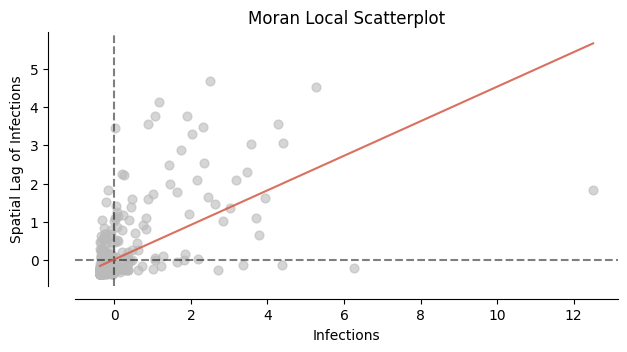

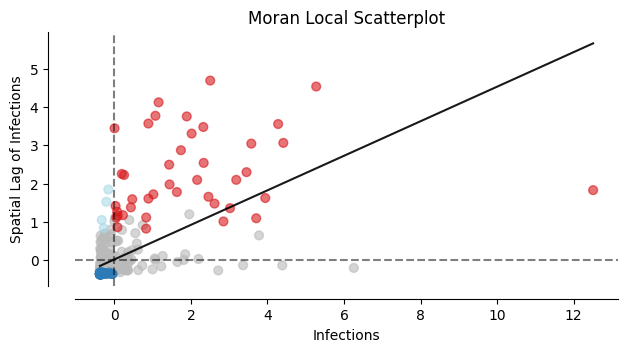

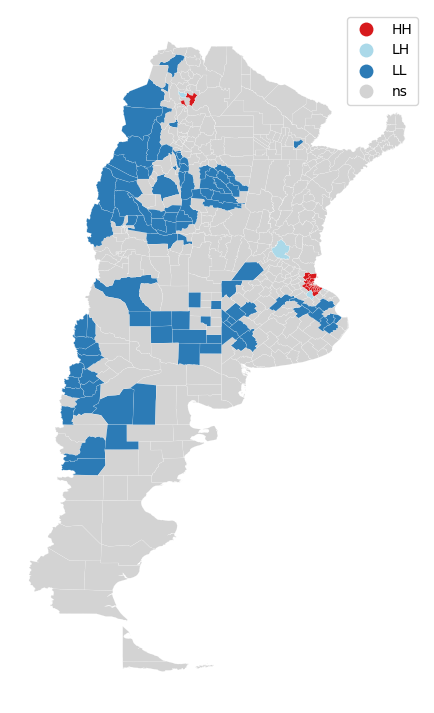

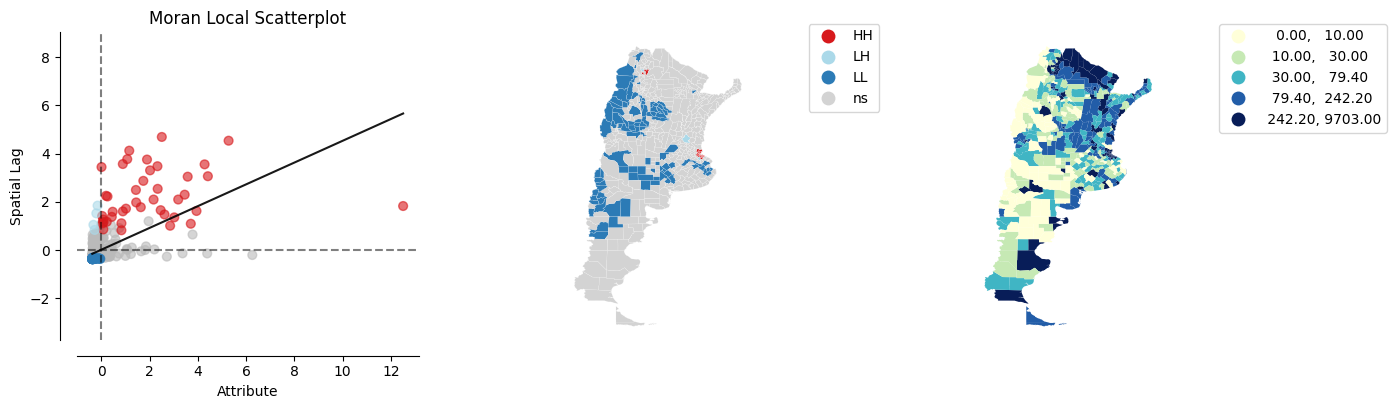

Department with the highest infections:
        provincia       departamen  infections  \
341  Buenos Aires  Lomas de Zamora      4255.0   

                                              geometry     lisa_I  lisa_p  \
341  POLYGON ((-58.46128 -34.70617, -58.46116 -34.7...  23.879975   0.001   

     lisa_cluster  HH  
341             1   1  
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')


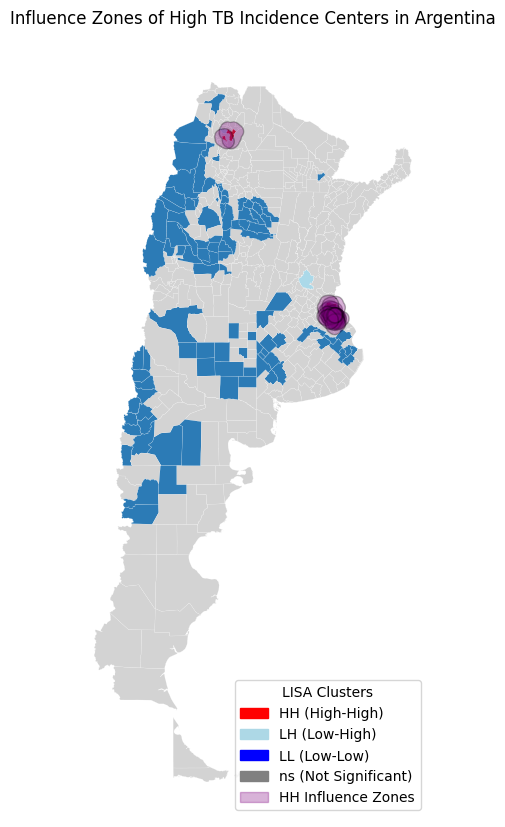

In [16]:
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import libpysal
import esda
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
def autocorrelacion_plot(df_prov, solo_mapa=0):
    """
    Plots the spatial autocorrelation of infection data using Moran's I and LISA.

    Args:
    df_prov (GeoDataFrame): Geospatial data containing infection counts.
    solo_mapa (int): If 1, only the LISA cluster map is displayed.

    Returns:
    GeoDataFrame: Updated with LISA results.
    """
    y = df_prov['infections'].values
    w = libpysal.weights.Queen.from_dataframe(df_prov)
    lisa = Moran_Local(y, w)

    # Add LISA results to the GeoDataFrame
    df_prov['lisa_I'] = lisa.Is
    df_prov['lisa_p'] = lisa.p_sim
    df_prov['lisa_cluster'] = lisa.q
    df_prov['HH'] = np.where((df_prov['lisa_cluster'] == 1) & (df_prov['lisa_p'] <= 0.05), 1, 0)

    if solo_mapa == 0:
        # Plot Moran scatterplot
        fig, ax = moran_scatterplot(lisa)
        ax.set_xlabel('Infections')
        ax.set_ylabel('Spatial Lag of Infections')
        plt.savefig('Documentacion\\figures\\morgan_scatter_grey.png', dpi=300)
        plt.show()

        fig, ax = moran_scatterplot(lisa, p=0.05)
        ax.set_xlabel('Infections')
        ax.set_ylabel('Spatial Lag of Infections')
        plt.savefig('Documentacion\\figures\\morgan_scatter.png', dpi=300)

        plt.show()

    # Show LISA clusters on the map
    lisa_cluster(lisa, df_prov, p=0.05, figsize=(9, 9))
    plt.savefig('Documentacion\\figures\\lisa.png', dpi=300)
    plt.show()



    if solo_mapa == 0:
        # Plot local autocorrelation
        plot_local_autocorrelation(lisa, df_prov, 'infections')
        plt.show()

    # Find the department with the highest LISA I value
    max_infections = lisa.Is.max()
    department_with_max_infections = df_prov.loc[df_prov['lisa_I'] == max_infections]

    print("Department with the highest infections:")
    print(department_with_max_infections)

    # Subset for departments with more than 10 infections
    df_prov_subset = df_prov[df_prov['infections'] < 5]
    y = df_prov_subset['infections'].values
    w = libpysal.weights.Queen.from_dataframe(df_prov_subset)
    moran_loc = Moran_Local(y, w)

    # Add Moran Local results to the DataFrame
    df_prov_subset['moran_Is'] = moran_loc.Is
    df_prov_subset['moran_p_sim'] = moran_loc.p_sim
    df_prov_subset['moran_q'] = moran_loc.q
    plot_lisa_with_influence(df_prov,lisa, p=0.05)

def plot_lisa_with_influence(df_prov, lisa, p=0.05):
    """
    Plot LISA clusters and add influence zones for high-incidence regions.

    Args:
    df_prov (GeoDataFrame): Geospatial data containing LISA results and infection counts.
    lisa (Moran_Local): LISA results.
    p (float): Significance level for hotspots.
    """

    # 🔹 Ensure projection is in meters (EPSG:3857) for proper distance calculations
    if df_prov.crs is None or df_prov.crs.to_epsg() != 3857:
        df_prov = df_prov.to_crs(epsg=3857)  

    # 🔹 Identify high-incidence regions (Hotspots)
    df_prov['HH'] = np.where((df_prov['lisa_cluster'] == 1) & (df_prov['lisa_p'] <= p), 1, 0)
    hotspots = df_prov[df_prov["HH"] == 1]

    # 🔹 Create influence zones (50 km buffer)
    if not hotspots.empty:
        hotspots["geometry"] = hotspots.geometry.buffer(50000)  # 50 km buffer

    # 🔹 Plot LISA map with influence zones
    fig, ax = plt.subplots(figsize=(10, 10))

    # LISA Cluster Map
    lisa_cluster(lisa, df_prov, p=p, ax=ax)

    # Overlay influence zones
    if not hotspots.empty:
        hotspots.plot(color="purple", alpha=0.3, ax=ax, edgecolor="black", label="HH Influence Zones")

    plt.title("Influence Zones of High TB Incidence Centers in Argentina")

    # 🔹 Custom Legend
    legend_elements = [
        mpatches.Circle((0, 0), radius=5, color="red", label="HH (High-High)"),
        mpatches.Circle((0, 0), radius=5, color="lightblue", label="LH (Low-High)"),
        mpatches.Circle((0, 0), radius=5, color="blue", label="LL (Low-Low)"),
        mpatches.Circle((0, 0), radius=5, color="grey", label="ns (Not Significant)"),
        mpatches.Circle((0, 0), radius=5, color="purple", alpha=0.3, label="HH Influence Zones")
    ]
    
    ax.legend(handles=legend_elements, loc="lower right", title="LISA Clusters")
    plt.savefig('Documentacion\\figures\\influencies.png', dpi=300)
    plt.show()
# Sort cases by the number of infections in descending order

cases_dept_area= cases_dept_area.rename(columns={'infecciones':'infections'})
cases_dept_area2 = cases_dept_area.sort_values(by=["infections"], ascending=False)
# cases_dept_area2=cases_dept_area2.loc[cases_dept_area2["infections"]>10]
# Perform spatial autocorrelation analysis on the sorted data
df_lisa = autocorrelacion_plot(cases_dept_area2[["provincia", "departamen", "infections", "geometry"]])


In [17]:
df_casos_activos_depto_fecha2 = df_casos_activos_depto_fecha.copy()
df_casos_activos_depto_fecha2=df_casos_activos_depto_fecha2.rename(columns={'infecciones':'infections'})
# Segment the analysis by date
ANALISIS_FECHA = False
if ANALISIS_FECHA:
    col_fechas = df_casos_activos_depto_fecha2.columns
    l_fechas = len(col_fechas)
    for i in range(2, l_fechas):
        # Print the current date column
        print(col_fechas[i])
        
        # Subset data for the current date
        df_fecha = df_casos_activos_depto_fecha2[["provincia", "departamento", col_fechas[i]]]
        df_fecha.columns = ["provincia", "departamen", "infections"]
        
        # Merge with shapefile data
        df_mexclado3 = pd.merge(dataframe_shp, df_fecha, on=["provincia", "departamen"], how="left")
        
        # Filter out rows with unknown or irrelevant provinces
        df_mexclado3 = df_mexclado3.loc[(df_mexclado3["provincia"] != "Desconocida") & (df_mexclado3["provincia"] != 'Tierra del Fuego')]

        # Select relevant columns for spatial analysis
        df_aux_vecindad = df_mexclado3.loc[(~df_mexclado3["codpcia"].isnull())][["departamen", "infections", "geometry"]]
        df_aux_vecindad = df_aux_vecindad.fillna(0)
        
        # Generate spatial autocorrelation plot
        autocorrelacion_plot(df_aux_vecindad, solo_mapa=1)


In [18]:
# Flag to control whether it should run for each provinc
ANALISIS_TOP = False
if ANALISIS_TOP:
    for t in cases_dept_area["provincia"].unique():
        if t != "Desconocida" and t != "Tierra del Fuego":
            # Standardize province name
            t = unidecode(str(t))
            print(t)
            
            # Subset data for the current province
            df_aux_vecindad = cases_dept_area.loc[(cases_dept_area["provincia"] == t) & (~cases_dept_area["codpcia"].isnull())].reset_index(drop=True)[["departamen", "infections", "geometry"]]

            # Generate spatial autocorrelation plot
            autocorrelacion_plot(df_aux_vecindad, solo_mapa=1)


In [24]:
# --- Ajustes / imports (deberías tenerlos ya) ---
import numpy as np
import libpysal
from esda.moran import Moran, Moran_Local

PERMUTATIONS = 999
P_THRESH = 0.05

def autocorrelacion_plot_2(df_prov, solo_mapa=0):
    """
    Plotea autocorrelación espacial (Moran's I y LISA) y devuelve LISA + stats globales.
    Usa tu columna 'infections' y geometría de df_prov (provincia, departamen, infections, geometry).
    """
    # --- CRS de análisis (topología es CRS-invariante; fijamos EPSG:4326 por claridad/repro) ---
    try:
        df_prov = df_prov.to_crs(4326)
    except Exception:
        # si ya está en 4326 o no tiene crs, intenta asignar o continúa
        if getattr(df_prov, "crs", None) is None:
            # si tu shapefile viene en 4326, descomenta la siguiente línea:
            # df_prov = df_prov.set_crs(4326)
            pass

    # --- variable de interés ---
    y = df_prov["infections"].astype(float).to_numpy()
    mask_valid = np.isfinite(y)
    if not mask_valid.all():
        df_prov = df_prov.loc[mask_valid].copy()
        y = y[mask_valid]

    # --- pesos queen + estandarización fila ---
    w = libpysal.weights.Queen.from_dataframe(df_prov)
    w.transform = "r"

    # --- Moran GLOBAL (lo que te pide el revisor) ---
    mi = Moran(y, w, permutations=PERMUTATIONS, two_tailed=True)
    moran_stats = {
        "n": int(w.n),
        "crs_analysis": "EPSG:4326",
        "I": float(mi.I),
        "Z": float(mi.z_norm),
        "p_norm": float(mi.p_norm),
        "p_perm": float(mi.p_sim),
        "permutations": PERMUTATIONS,
        "two_tailed": True,
    }
    print("Global Moran's I:", moran_stats)

    # --- LISA ---
    lisa = Moran_Local(y, w, permutations=PERMUTATIONS)
    df_prov["lisa_I"] = lisa.Is
    df_prov["lisa_p"] = lisa.p_sim
    # 1=HH, 2=LH, 3=LL, 4=HL
    labels = np.array(["NS", "HH", "LH", "LL", "HL"])[lisa.q]
    sig = lisa.p_sim < P_THRESH
    df_prov["lisa_quad"] = np.where(sig, labels, "NS")

    # --- resumen para Results (rápido) ---
    counts = {
        "HH": int((df_prov["lisa_quad"] == "HH").sum()),
        "LL": int((df_prov["lisa_quad"] == "LL").sum()),
        "HL": int((df_prov["lisa_quad"] == "HL").sum()),
        "LH": int((df_prov["lisa_quad"] == "LH").sum()),
        "NS": int((df_prov["lisa_quad"] == "NS").sum()),
    }
    print(f"LISA counts (p < {P_THRESH}):", counts)

    # --- tu plotting existente se mantiene igual (moran_scatterplot, lisa_cluster, etc.) ---
    # (Deja aquí tus llamadas a moran_scatterplot / lisa_cluster / plot_local_autocorrelation si ya las tienes.)

    # Texto listo para pegar en Results:
    print(
        "Global spatial autocorrelation — Moran's I = {I:.3f}, Z = {Z:.2f}, "
        "p_norm = {p_norm:.3g}, p_perm = {p_perm:.3g} (n = {n}, permutations = {permutations})."
        .format(**moran_stats)
    )

    return df_prov, moran_stats
# Flag to control whether it should run for each provinc
df_lisa_2 = autocorrelacion_plot_2(cases_dept_area2[["provincia", "departamen", "infections", "geometry"]])

Global Moran's I: {'n': 525, 'crs_analysis': 'EPSG:4326', 'I': 0.4513179340306984, 'Z': 16.5840454321128, 'p_norm': 9.089849616351815e-62, 'p_perm': 0.001, 'permutations': 999, 'two_tailed': True}
LISA counts (p < 0.05): {'HH': 43, 'LL': 92, 'HL': 0, 'LH': 5, 'NS': 385}
Global spatial autocorrelation — Moran's I = 0.451, Z = 16.58, p_norm = 9.09e-62, p_perm = 0.001 (n = 525, permutations = 999).


In [25]:
df_lisa_2

(        provincia       departamen  infections  \
 332  Buenos Aires       La Matanza      9703.0   
 471      Santa Fe          Rosario      4995.0   
 341  Buenos Aires  Lomas de Zamora      4255.0   
 391  Buenos Aires          Quilmes      3608.0   
 362         Salta          Capital      3587.0   
 ..            ...              ...         ...   
 116        Chubut   Paso de Indios         0.0   
 176      La Pampa    Limay Mahuida         0.0   
 175      La Pampa     Lihuel Calel         0.0   
 169      La Pampa           Curacó         0.0   
 26        Cordoba            Pocho         0.0   
 
                                               geometry     lisa_I  lisa_p  \
 332  POLYGON ((-58.52885 -34.65516, -58.52847 -34.6...  22.830800   0.001   
 471  POLYGON ((-60.69614 -32.83999, -60.69611 -32.8...  -1.273525   0.436   
 341  POLYGON ((-58.46128 -34.70617, -58.46116 -34.7...  23.879975   0.001   
 391  POLYGON ((-58.33361 -34.728, -58.33303 -34.727...  13.498815   0.001